# Koronaviruksen jätevesiseuranta

Jätevesitilasto © THL (lisenssillä [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.fi))

https://www.thl.fi/episeuranta/jatevesi/jatevesiseuranta_viikkoraportti.html

In [1]:
from datetime import datetime
from jatevedet_fi_thl import *

In [2]:
%config InlineBackend.figure_formats = ['png2x']  # png, png2x, jpg, svg
view_dpi = 90

In [3]:
data = pd.read_csv("data/Koronaviruksen jätevesiseurannan viikkoraportti 2022-10-28.csv",
                   parse_dates=["Näytteen päivämäärä"], date_parser=datetime.fromisoformat)

In [4]:
data.iloc[:20]

,Näytteen päivämäärä,Puhdistamo,Puhdistamon sijainti,Puhdistamon asiakasmäärä,Sairaanhoitopiiri,Koronavirustulos näytteestä,Epävarmuustekijät,Virtaama,Virtaamakorjattu RNA-lukumäärä
0,2022-10-24,Suomenoja,Espoo,390000,Helsingin ja Uudenmaan SHP,"havaittu, yli määritysrajan",b,79643,525017.0
1,2022-10-24,Viikinmäki,Helsinki,860000,Helsingin ja Uudenmaan SHP,"havaittu, yli määritysrajan",b,206160,389470.0
2,2022-10-24,Kuhasalo,Joensuu,98000,Pohjois-Karjalan SHP,"havaittu, yli määritysrajan",NaN,15212,402076.0
3,2022-10-24,Nenäinniemi,Jyväskylä,154600,Keski-Suomen SHP,"havaittu, yli määritysrajan",b,34272,603074.0
4,2022-10-24,Lehtoniemi,Kuopio,90697,Pohjois-Savon SHP,"havaittu, yli määritysrajan",b,19290,899990.0
5,2022-10-24,Toikansuo,Lappeenranta,63000,Etelä-Karjalan SHP,"havaittu, yli määritysrajan",b,10413,465474.0
6,2022-10-24,Taskila,Oulu,200000,Pohjois-Pohjanmaan SHP,"havaittu, yli määritysrajan",b,41436,313822.0
7,2022-10-24,Alheda,Pietarsaari,30500,Vaasan SHP,"havaittu, yli määritysrajan",b,7078,95841.0
8,2022-10-24,Alakorkalo,Rovaniemi,55000,Lapin SHP,"havaittu, yli määritysrajan",NaN,11240,1015274.0
9,2022-10-24,Seinäjoenkeskuspuhdistamo,Seinäjoki,55000,Etelä-Pohjanmaan SHP,"havaittu, yli määritysrajan",NaN,15000,181061.0


In [5]:
df, dates, mittaukset_n, epvt_n, kaikki_puhdistamot = valmistele_data(data)

# Valitaan viikottain päivittyvät puhdistamot
puhdistamot = [
    "Helsinki, Viikinmäki",
    "Espoo, Suomenoja",
    "Jyväskylä, Nenäinniemi",
    "Tampere, Viinikanlahti",
    "Joensuu, Kuhasalo",
    "Oulu, Taskila",
    "Kuopio, Lehtoniemi",
    "Turku, Kakolanmäki",
    "Vaasa, Pått",
]
muut_puhdistamot = kaikki_puhdistamot.difference(puhdistamot)

# Järjestetään puhdistamot asiakasmäärien mukaan laskevasti
asiakasmaarat = df["Puhdistamon asiakasmäärä"][puhdistamot].max(axis=0)
puhdistamot = np.array(puhdistamot)[np.argsort(asiakasmaarat)[::-1]]

keskiarvot, painotetut_ka = trendien_keskiarvot(df, puhdistamot)

Ikkunan leveys
  Ikkunan painosta 100%: 63.0 päivää (kertoimia 127 kpl)
  Ikkunan painosta 51.06% >= 50%: 14.0 päivää
  Ikkunan painosta 80.19% >= 80%: 26.0 päivää
  Ikkunan painosta 90.24% >= 90%: 33.0 päivää
  Ikkunan painosta 95.42% >= 95%: 39.0 päivää
  Ikkunan painosta 99.04% >= 99%: 48.0 päivää


## Muut puhdistamot

Harvemmin kuin viikon välein päivittyvät puhdistamot ja ne puhdistamot joilla koronaviruksen jätevesiseuranta on päättynyt:

In [6]:
print(*muut_puhdistamot, sep="\n")

Hämeenlinna, Paroinen
Kajaani, Peuraniemi
Kemi, Peurasaari
Kokkola, Hopeakivenlahti
Kotka, Mussalo
Kouvola, Mäkikylä
Lahti, Ali-Juhakkala
Lahti, Kariniemi
Lappeenranta, Toikansuo
Maarianhamina, Lotsbroverket
Mikkeli, Kenkäveronniemi
Pietarsaari, Alheda
Pori, Luotsinmäki
Rauma, Maanpäänniemi
Rovaniemi, Alakorkalo
Salo, keskuspuhdistamo
Savonlinna, Pihlajaniemi
Seinäjoki, keskuspuhdistamo
Vihti, Nummela


## Epävarmuustekijät viimeaikaisissa näytteissä

Sarakkeen [kuvauksesta](https://www.thl.fi/episeuranta/jatevesi/jatevesiseuranta_viikkoraportti.html):

> Taulukkoriville on lisätty kirjainsymboli (a, b tai c), mikäli saatuun SARS-CoV-2 koronaviruksen RNA-tuloksen analysointiin liittyy yksi tai useampi tuloksen luotettavuutta heikentävä epävarmuustekijä.
> 
> * a = näytteen lämpötila yli 15 astetta näytteen saapuessa laboratorioon.
> * b = näytteessä on todettu määritystä häiritseviä tekijöitä (inhibitio).
> * c = yli 14vrk viive näytteen keräämisen ja analyysin aloituksen välillä, kertanäyte tai poikkeava keräysaika.
> * () = epävarmuustekijää ei ole testattu tai tieto puuttuu.


In [7]:
df["Epävarmuustekijät"][puhdistamot].loc[dates].iloc[-1:-9:-1].T

,2022-10-24,2022-10-17,2022-10-10,2022-10-03,2022-09-26,2022-09-19,2022-09-12,2022-09-06
Puhdistamo,,,,,,,,
"Helsinki, Viikinmäki",b,b,NaN,NaN,NaN,NaN,NaN,NaN
"Espoo, Suomenoja",b,NaN,b,NaN,NaN,NaN,NaN,NaN
"Turku, Kakolanmäki",NaN,b,NaN,NaN,NaN,NaN,NaN,NaN
"Oulu, Taskila",b,NaN,b,NaN,NaN,NaN,NaN,NaN
"Tampere, Viinikanlahti",b,b,NaN,NaN,NaN,NaN,NaN,NaN
"Jyväskylä, Nenäinniemi",b,NaN,b,NaN,NaN,NaN,NaN,NaN
"Joensuu, Kuhasalo",NaN,b,b,NaN,NaN,b,NaN,NaN
"Kuopio, Lehtoniemi",b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Vaasa, Pått",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
xlim = {
    "left": dates[-1] - np.timedelta64(12 * 28 + 2, "D"),
    "right": dates[-1] + np.timedelta64(2, "D"),
}

## Historiaan suhteutettujen mittaustulosten jakauma koko maassa

Kunkin puhdistamon virtaamakorjattuun dataan on sovitettu trendi (liukuva keskiarvo), joka tasoittaa viikottaista vaihtelua. Yllä tuloste ikkunan leveydestä kertoo, kuinka pitkältä aikaväliltä mittaustuloksia huomioidaan. Puhdistamon data normalisoidaan jakamalla jokainen virtaamakorjattu mittaustulos trendikäyrän maksimiarvolla. Puhdistamon mittaustuloksia verrataan siis sen omaan menneisyyteen – sen tähän asti pahimpaan epidemiatilanteeseen.

Normalisoinnin yksi tarkoitus on häivyttää alueiden väliset tuntemattomat erot vakio-olosuhteissa, jotka voivat ilmetä paikallisina eroina koronan leviämiskyvyssä tai sairastuneen tuottaman jätevesisignaalin voimakkuudessa. Lisäksi normalisoitujen mittaustulosten jakauman muutokset havainnollistavat hyvin paikallisten epidemiatilanteiden muutoksia ja "samantahtisuutta" koko maassa.

Alla olevassa kaaviossa on normalisoitujen mittaustulosten jakauma ajan funktiona.

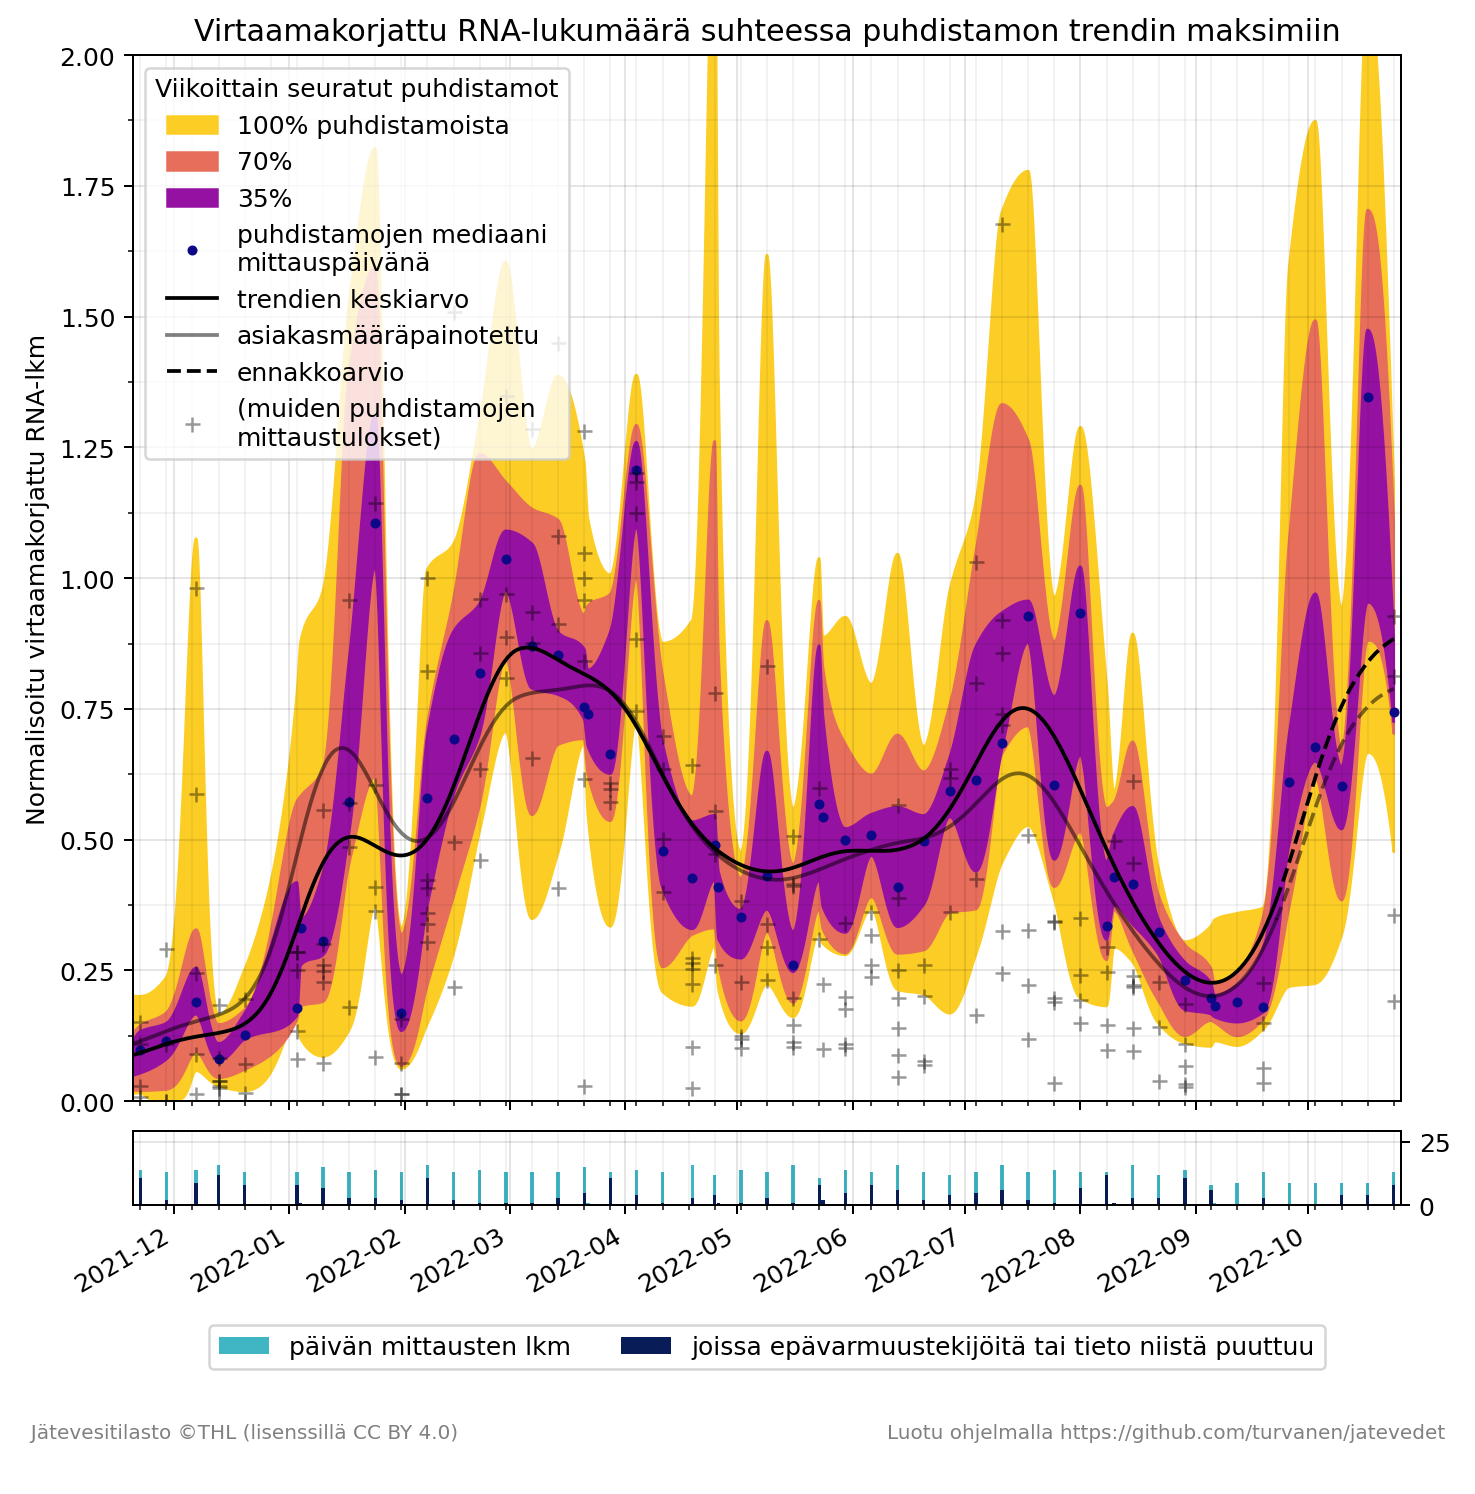

In [9]:
fig, ax = jakaumakaavio(df, dates, mittaukset_n, epvt_n, puhdistamot, 
                        keskiarvot=keskiarvot,
                        painotetut_ka=painotetut_ka,
                        xlim_kw=xlim,
                        dpi=view_dpi)
muita = len(muut_puhdistamot)
ax[0].plot(df.index, df["Normalisoitu RNA-lkm"][muut_puhdistamot], "k+", alpha=0.4,
           label=["(muiden puhdistamojen\nmittaustulokset)"] + [None] * (muita - 1))
ax[0].legend(title="Viikoittain seuratut puhdistamot", loc="upper left")

## Trendit

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot: title={'center': 'Virtaamakorjattu RNA-lukumäärä suhteessa puhdistamon trendin maksimiin'}, ylabel='Normalisoitu virtaamakorjattu RNA-lkm'>)

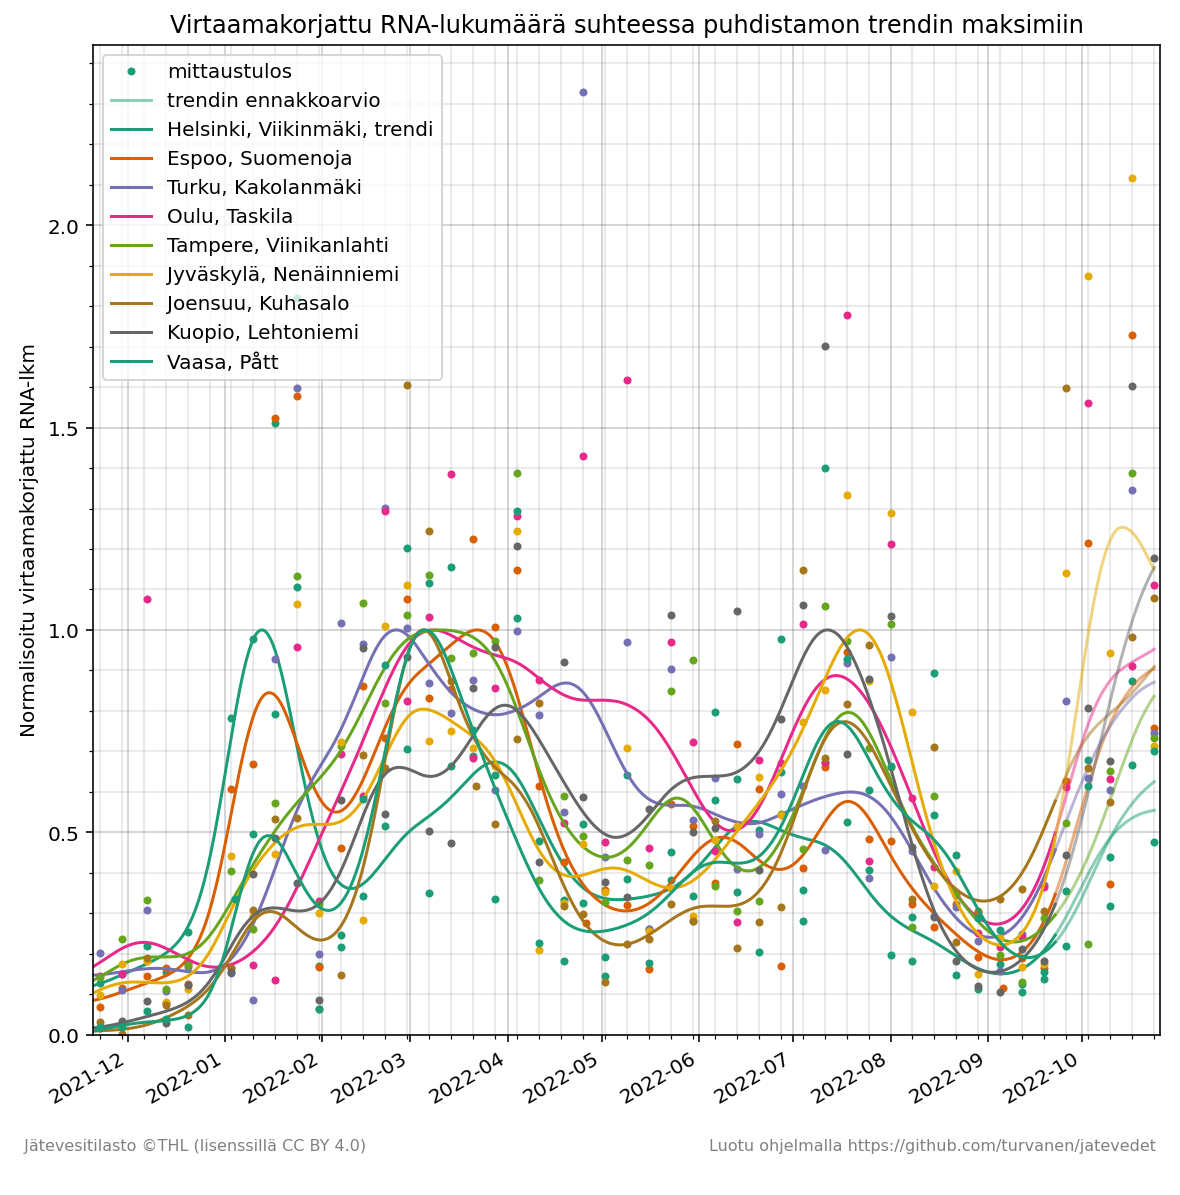

In [10]:
trendikaavio(df, puhdistamot, xlim_kw=xlim)

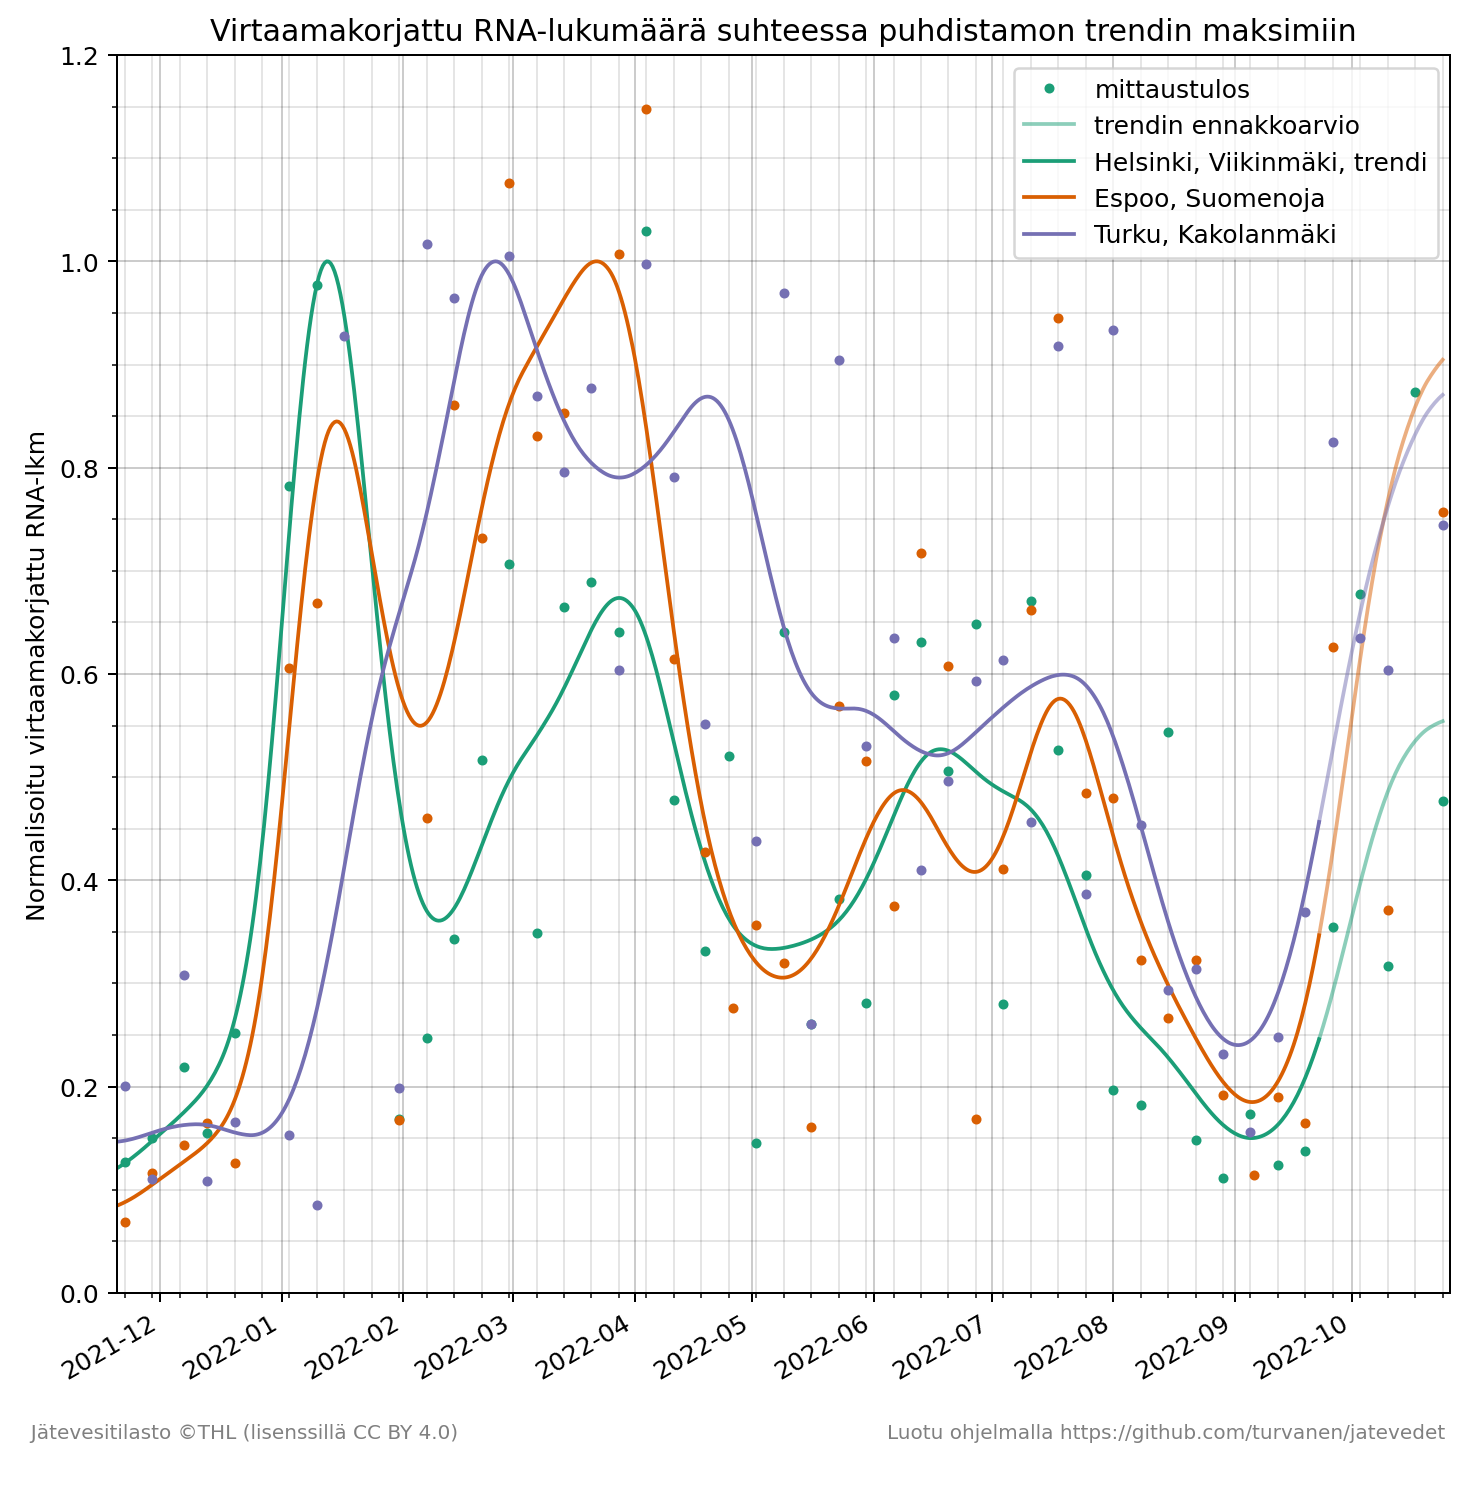

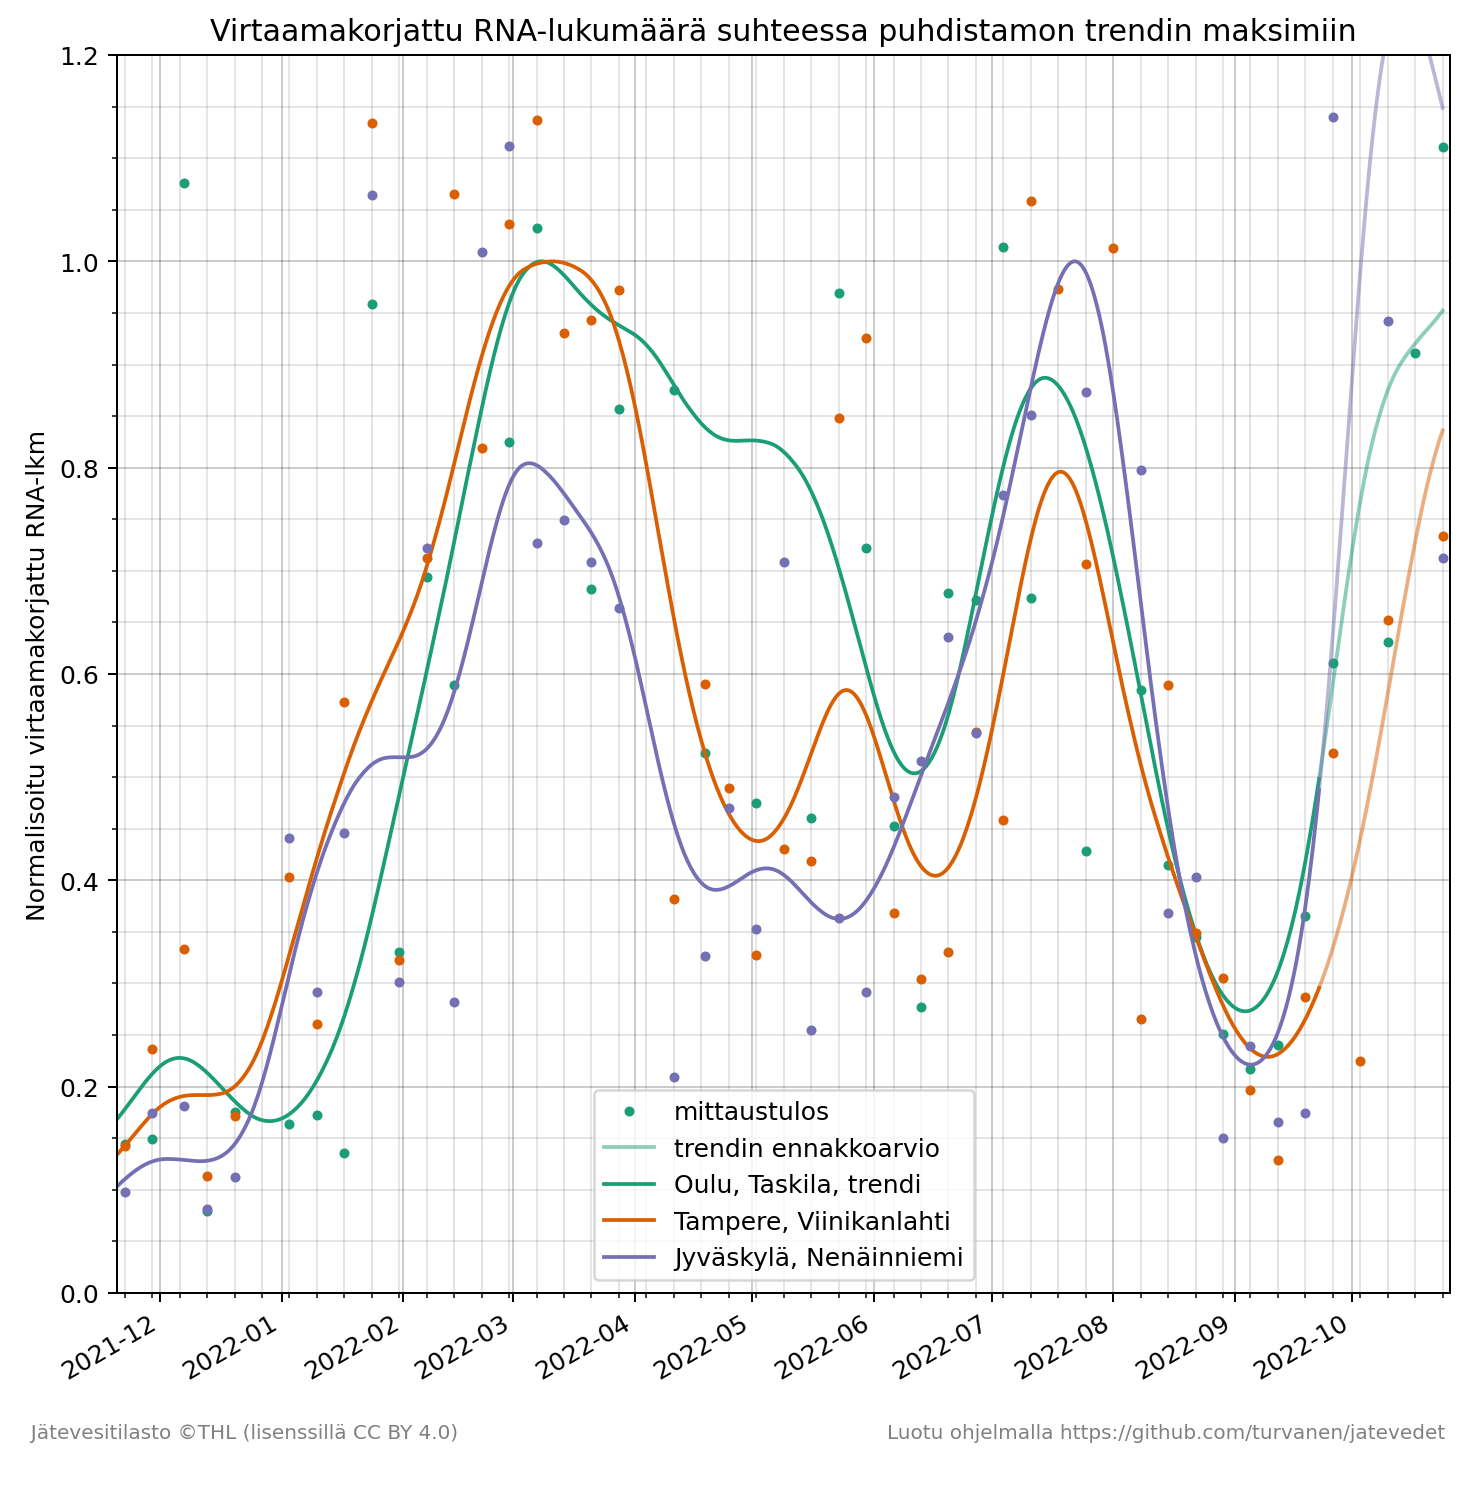

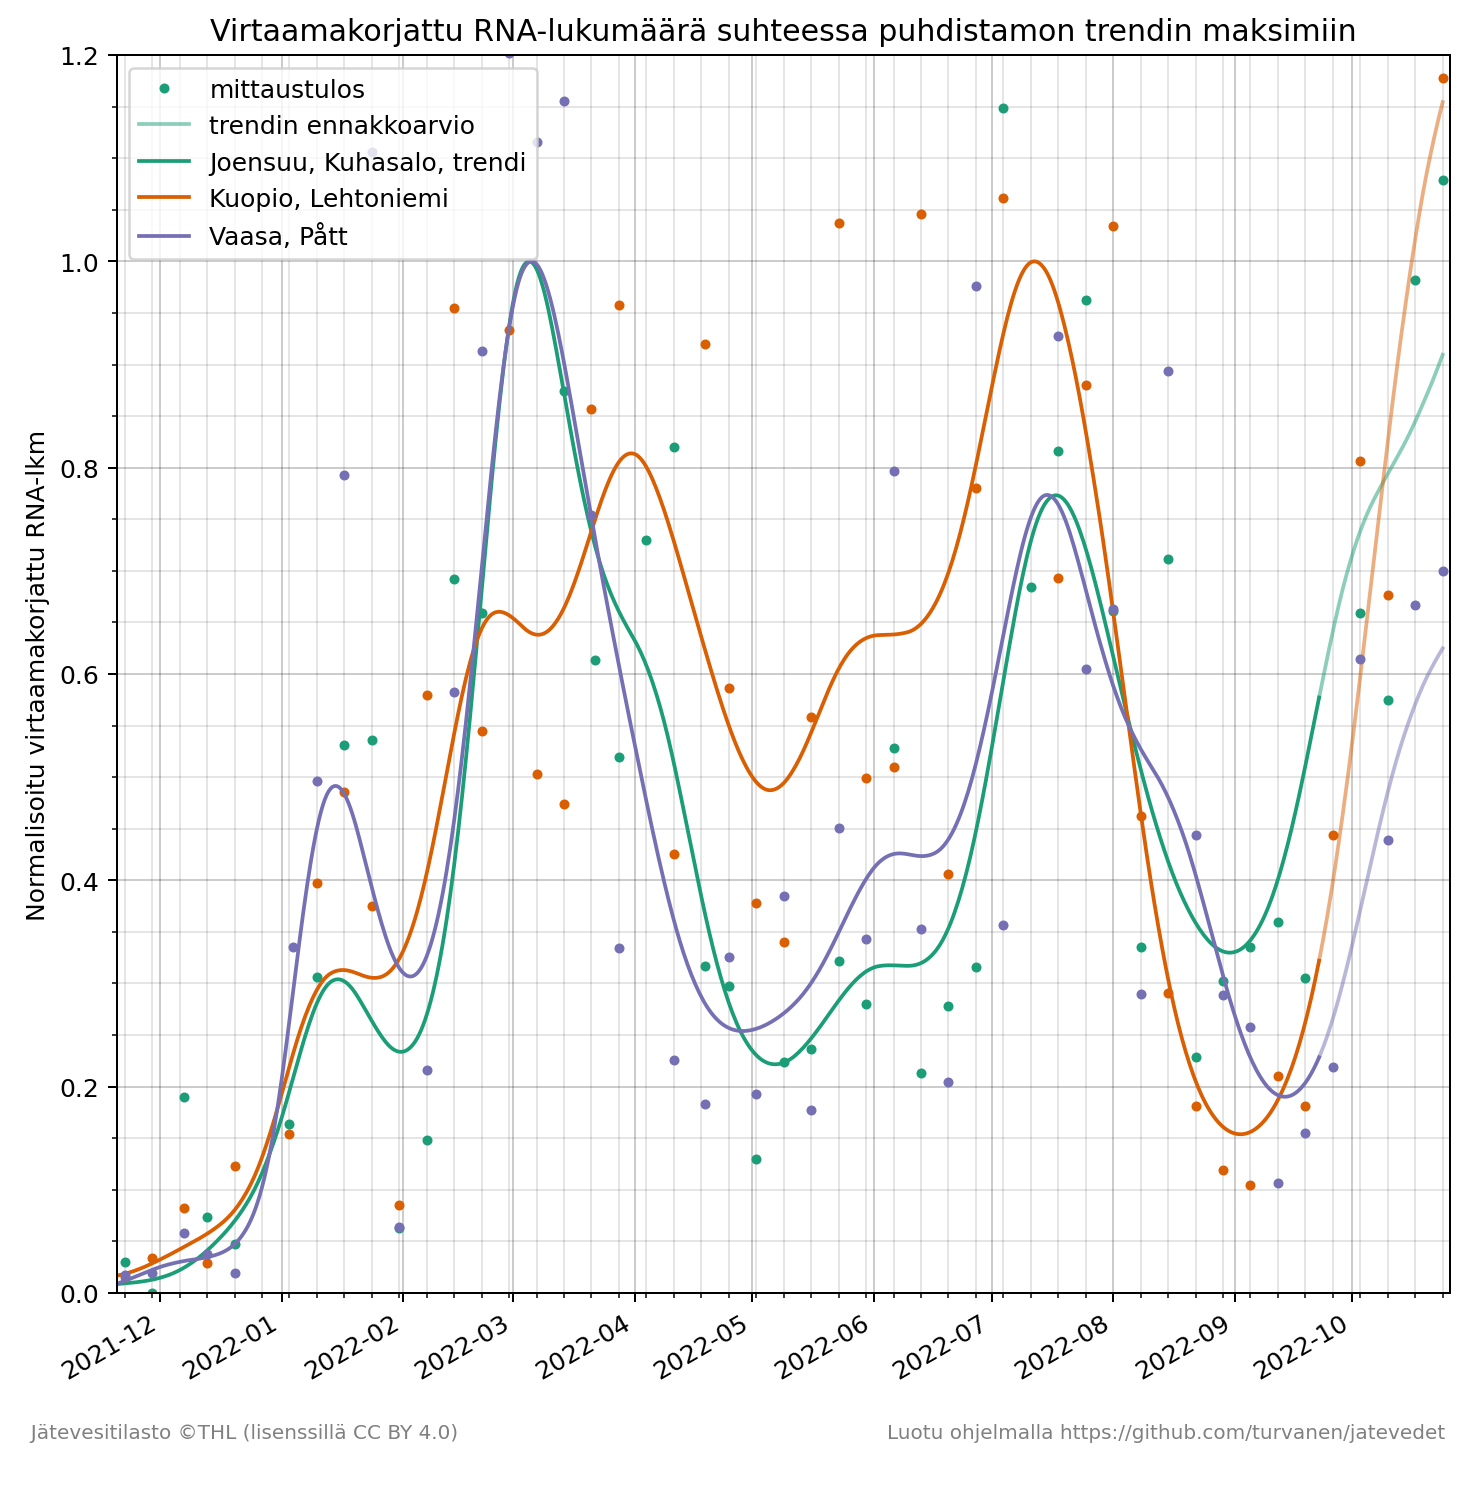

In [11]:
N = np.cumsum([0, 3, 3, 3])
assert N[-1] == len(puhdistamot)

for i in range(len(N) - 1):
    fig, ax = trendikaavio(df, puhdistamot[N[i]:N[i+1]],
                           xlim_kw=xlim, 
                           ylim_kw={"top": 1.2},
                           dpi=view_dpi)

## Puhdistamon kolmen viimeisen mittaustuloksen sijoitukset

Eli mittauspäivien järjestysluvut rankinglistalla.

In [12]:
for p in puhdistamot:
    ranking = df["Virtaamakorjattu RNA-lukumäärä"][p].dropna(how="all").rank(ascending=False, method="min").iloc[-3:]
    display(ranking)

2022-10-10    30.0
2022-10-17     5.0
2022-10-24    23.0
Name: Helsinki, Viikinmäki, dtype: float64

2022-10-10    30.0
2022-10-17     1.0
2022-10-24    13.0
Name: Espoo, Suomenoja, dtype: float64

2022-10-10    24.0
2022-10-17     3.0
2022-10-24    19.0
Name: Turku, Kakolanmäki, dtype: float64

2022-10-10    25.0
2022-10-17    15.0
2022-10-24     9.0
Name: Oulu, Taskila, dtype: float64

2022-10-10    19.0
2022-10-17     1.0
2022-10-24    16.0
Name: Tampere, Viinikanlahti, dtype: float64

2022-10-10    10.0
2022-10-17     1.0
2022-10-24    18.0
Name: Jyväskylä, Nenäinniemi, dtype: float64

2022-10-10    19.0
2022-10-17     6.0
2022-10-24     5.0
Name: Joensuu, Kuhasalo, dtype: float64

2022-10-10    18.0
2022-10-17     2.0
2022-10-24     4.0
Name: Kuopio, Lehtoniemi, dtype: float64

2022-10-10    23.0
2022-10-17    15.0
2022-10-24    14.0
Name: Vaasa, Pått, dtype: float64

In [13]:
for p in muut_puhdistamot:
    ranking = df["Virtaamakorjattu RNA-lukumäärä"][p].dropna(how="all").rank(ascending=False, method="min").iloc[-3:]
    display(ranking)

2022-08-15    30.0
2022-08-22    36.0
2022-08-29    43.0
Name: Hämeenlinna, Paroinen, dtype: float64

2021-05-03    15.0
2021-05-17    15.0
2021-05-31    15.0
Name: Kajaani, Peuraniemi, dtype: float64

2021-05-03    6.0
2021-05-17    8.0
2021-05-31    8.0
Name: Kemi, Peurasaari, dtype: float64

2021-05-03    9.0
2021-05-17    1.0
2021-05-31    2.0
Name: Kokkola, Hopeakivenlahti, dtype: float64

2021-05-03    12.0
2021-05-17     2.0
2021-05-31    17.0
Name: Kotka, Mussalo, dtype: float64

2022-08-15    29.0
2022-08-22    39.0
2022-08-29    41.0
Name: Kouvola, Mäkikylä, dtype: float64

2021-05-03    5.0
2021-05-17    1.0
2021-05-31    7.0
Name: Lahti, Ali-Juhakkala, dtype: float64

2021-05-03    3.0
2021-05-17    2.0
2021-05-31    7.0
Name: Lahti, Kariniemi, dtype: float64

2022-08-29    36.0
2022-09-19    31.0
2022-10-24     6.0
Name: Lappeenranta, Toikansuo, dtype: float64

2021-05-03     4.0
2021-05-17    18.0
2021-05-31    18.0
Name: Maarianhamina, Lotsbroverket, dtype: float64

2021-05-03    18.0
2021-05-17     5.0
2021-05-31     5.0
Name: Mikkeli, Kenkäveronniemi, dtype: float64

2022-08-15     7.0
2022-09-19    11.0
2022-10-24     6.0
Name: Pietarsaari, Alheda, dtype: float64

2022-08-10    12.0
2022-08-15    22.0
2022-08-29    37.0
Name: Pori, Luotsinmäki, dtype: float64

2021-05-03     4.0
2021-05-17     4.0
2021-05-31    17.0
Name: Rauma, Maanpäänniemi, dtype: float64

2022-08-29    22.0
2022-09-19    16.0
2022-10-24     5.0
Name: Rovaniemi, Alakorkalo, dtype: float64

2021-05-03    2.0
2021-05-17    5.0
2021-05-31    5.0
Name: Salo, keskuspuhdistamo, dtype: float64

2021-05-03    12.0
2021-05-17    14.0
2021-05-31    14.0
Name: Savonlinna, Pihlajaniemi, dtype: float64

2022-08-15    4.0
2022-09-19    9.0
2022-10-24    6.0
Name: Seinäjoki, keskuspuhdistamo, dtype: float64

2021-04-19    7.0
2021-05-03    1.0
2021-05-31    7.0
Name: Vihti, Nummela, dtype: float64

## Puhdistamojen virtaaman vaihtelu

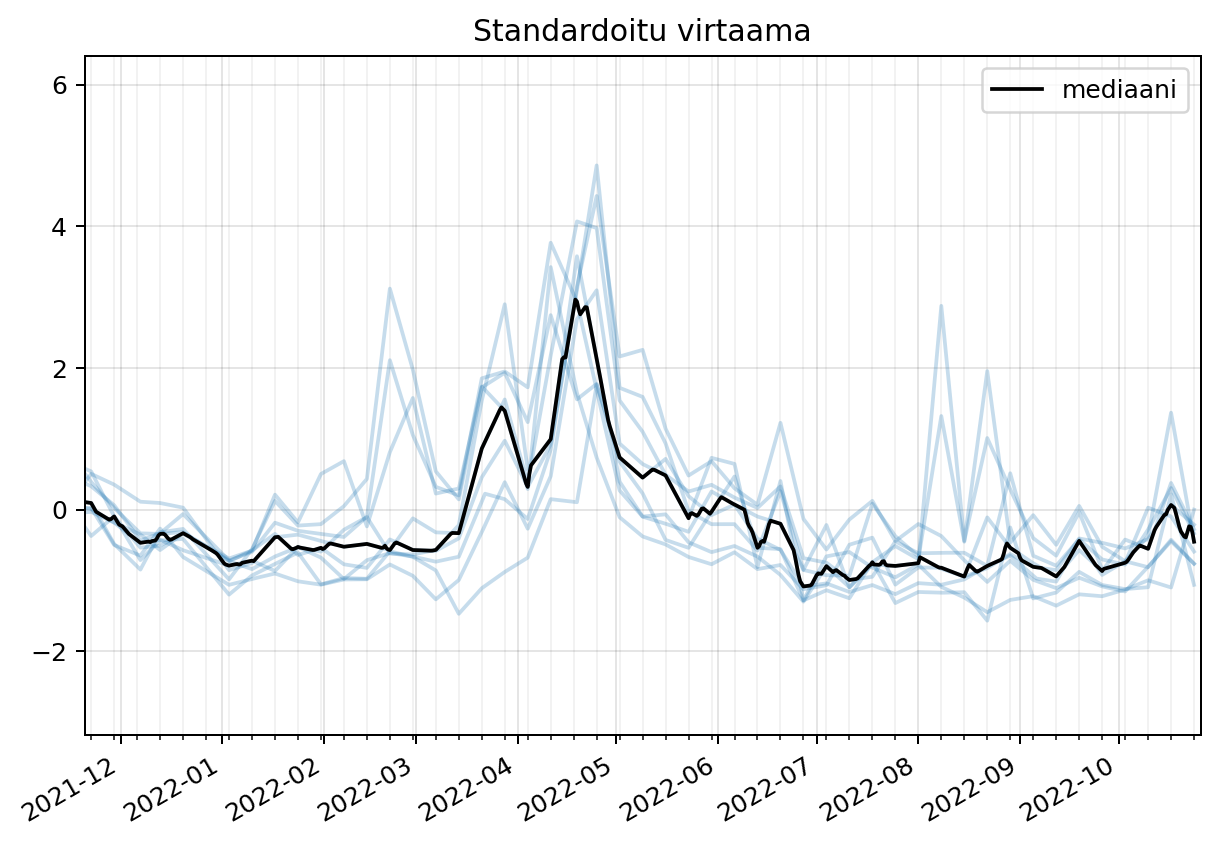

In [14]:
virtaamat = df["Virtaama"][puhdistamot]
virtaamat_std = (virtaamat.interpolate(axis=0) - virtaamat.mean(axis=0)) / virtaamat.std(axis=0)
virtaamat_std_m = virtaamat_std.median(axis=1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=view_dpi)
plt.plot(df.index, virtaamat_std, "C0-", alpha=.25)
plt.plot(df.index, virtaamat_std_m, "k-", label="mediaani")
plt.title("Standardoitu virtaama")
ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
ax.grid(which="major", axis="both", c="k", alpha=0.1)
ax.grid(which="minor", axis="both", c="k", alpha=0.05)
plt.xticks(rotation=30, ha="right")
plt.xlim(**xlim)
plt.legend()